# CS 1656 – Introduction to Data Science (Spring 2020) 

## Instructor: Alexandros Labrinidis and Evangelos Karageorgos /Teaching Assistant: Xiaoting Li

## Term Project 

**Released: March 23, 2020**

**Due: April 21, 2020**

In [1]:
# Your name: James Brennan
# Your github ID: jtb117
# Your pitt username: jtb117

### Goal
The goal of this project is to expose you with a real data science problem, looking at the end-to-end pipeline. 

### What to do 
You are asked to write a Python Jupyter notebook, called `pgh_bike_analysis.ipynb` that will:
* [Task 1] access historical bike rental data for 2019 from HealthyRidePGH and summarize the rental data  
* [Task 2] create graphs to show the popularity of the different rental stations, given filter conditions  
* [Task 3] create graphs to show the rebalancing issue  
* [Task 4] cluster the data to group similar stations together, using a variety of clustering functions and visualize the results of the clustering.  

**Your program should not take more than 15 minutes to run**

### Jupyter Notebook Rules
This skeleton is provided for you to complete the project. Please add your code in the code cells below each Task. Feel free to add cells as needed. Do not remove existing cells.

In [4]:
import matplotlib.pyplot as plt
import pandas as pd

# Feel free to add here any other libraries as specified in the project description
import datetime as dt
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics.cluster.unsupervised import silhouette_score
from collections import Counter

For the sake of interactive display in Jupyter, we will enable matplotlib inline.

In [9]:
%matplotlib inline

--- 
Add your code below this line

---
### Task 1

In this task you will need to access historical bike rental data for 2019 from HealthyRidePGH and summarize the rental data.

### Task 1.1

In [10]:
# Imports csv
def imp_csv(fname, time):
    df = pd.read_csv(fname,sep=',',engine='python')
    if time :
        df['Starttime'] = pd.to_datetime(df['Starttime'])
    df = df.rename(columns = 
                  {'From station id':'from_id', 'Trip id':'trip_id',
                   'To station id':'to_id','From station name':'from_name',
                   'To station name':'to_name'})
    return df

# Obtain breakdown for Dataframe and group by a given time interval
def get_ftr(df, group):
    fromCNT = df.groupby('from_id').resample(group).count()['trip_id']
    toCNT   = df.groupby('to_id').resample(group).count()['trip_id']

    fromCNT = fromCNT.rename('fromCNT')
    fromCNT.index = fromCNT.index.rename(['station_id','date'])
    toCNT   = toCNT.rename('toCNT')
    toCNT.index = toCNT.index.rename(['station_id','date'])
    f_df = pd.DataFrame(data = [fromCNT]).transpose()
    t_df = pd.DataFrame(data = [toCNT]).transpose()
    
    ret = f_df.merge(t_df, on=['station_id','date'])
    # rebalCNT represents an estiamte of rebalancing at bike stations
    ret['rebalCNT'] = ret['fromCNT'] - ret['toCNT']
    
    if   group == 'H':
        ret.index.names = ['station_id', 'hour']
        ret.index = ret.index.map(lambda x: (x[0], x[1].hour))
    elif group == 'M':
        ret.index.names = ['station_id', 'month']
        ret.index = ret.index.map(lambda x: (x[0], x[1].month))
    return ret

# Import data
file_name_template = 'HealthyRideRentals2019-Q'
inp_df = imp_csv(file_name_template+'1.csv', True)
for i in range(2,4):
        temp =imp_csv(file_name_template+str(i)+'.csv',True)
        inp_df = inp_df.append(temp)
full_df = inp_df
inp_df  = inp_df.set_index('Starttime')
full_df['date_only'] = full_df['Starttime'].apply( 
        lambda full_df : dt.datetime(
            year=full_df.year, month=full_df.month, day=full_df.day
            )
        )	
full_df = full_df.set_index('date_only',drop=True,inplace=False)

# Represent daily breakdown
task1_1 = get_ftr(full_df, 'D')
print(task1_1.head(n=20))

                       fromCNT  toCNT  rebalCNT
station_id date                                
1000.0     2019-01-01        4      4         0
           2019-01-02        2      0         2
           2019-01-03        0      3        -3
           2019-01-04        2      1         1
           2019-01-05        5      5         0
           2019-01-06        1      2        -1
           2019-01-07        2      2         0
           2019-01-08        2      1         1
           2019-01-09        2      0         2
           2019-01-10        1      1         0
           2019-01-11        1      0         1
           2019-01-12        0      2        -2
           2019-01-13        0      1        -1
           2019-01-14        0      1        -1
           2019-01-15        3      6        -3
           2019-01-16        1      0         1
           2019-01-17        0      3        -3
           2019-01-18        2      0         2
           2019-01-19        3      1   

### Task 1.2

In [11]:
# Represent monthly breakdown
task1_2 = get_ftr(full_df, 'M')
print(task1_2.head(n=20))

                  fromCNT  toCNT  rebalCNT
station_id month                          
1000.0     1           35     43        -8
           2           51     58        -7
           3          132    174       -42
           4          392    434       -42
           5          601    654       -53
           6          666    719       -53
           7          672    693       -21
           8          586    640       -54
           9          522    564       -42
1001.0     1           59     82       -23
           2           61     80       -19
           3          117    134       -17
           4          276    332       -56
           5          429    500       -71
           6          498    522       -24
           7          552    605       -53
           8          470    539       -69
           9          415    462       -47
1002.0     1           36     28         8
           2           51     48         3


---
### Task 2

In this task you will need to create graphs to show the popularity of the different rental stations, given filter conditions.

In [40]:
# FILTER VARIABLES
filter_month = 4
filter_stationID = 1046


### Task 2.1

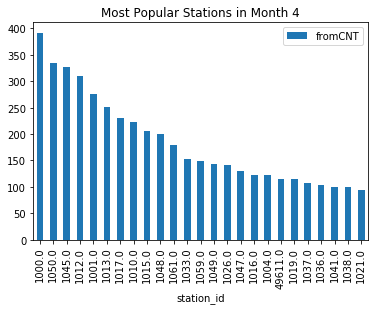

In [43]:
# Find most popular stations for the given month
task2_1_temp = task1_2.reset_index(level=1)
task2_1_temp = task2_1_temp[task2_1_temp.month == filter_month]
task2_1 = task2_1_temp.drop(columns='month').sort_values(by='fromCNT',ascending=False)
title2_1 = 'Most Popular Stations in Month '+str(filter_month)
task2_1.head(n=25).plot(kind='bar',y='fromCNT',legend=True,title=title2_1)

### Task 2.2

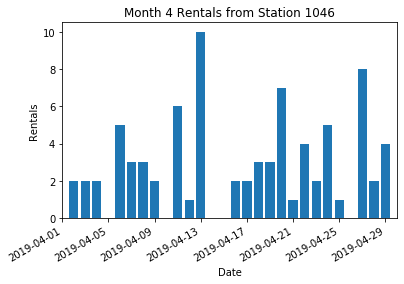

In [48]:
# Display distribution of bike rentals throughout the filter month, for the filter station only

# get a list of dates to include
st_m = str(filter_month)
if len(st_m) < 2:
    st_m = '0'+st_m
end_m = str(filter_month+1)
if len(end_m) < 2:
    end_m = '0'+end_m
start  = '2019-'+st_m+'-01'
finish = '2019-'+end_m+'-01'
dats = pd.date_range(start=start, end=finish, closed='left')
dates = []
for x in dats:
    dates.append(x.date())

# get intersection of selected dates and dataframe
task2_2 = task1_1.reset_index()
task2_2 = task2_2[task2_2.station_id == filter_stationID]
task2_2 = task2_2[task2_2.date.isin(dates)]

# plotting
fig, ax = plt.subplots()
ax.bar(x=task2_2['date'],height=task2_2['fromCNT'])
ax.xaxis_date()
fig.autofmt_xdate()
ax.set_xlim([dates[0], dates[-1]])
plt.title('Month '+str(filter_month)+' Rentals from Station '+str(int(filter_stationID)))
plt.ylabel('Rentals')
plt.xlabel('Date')
plt.show()

### Task 2.3

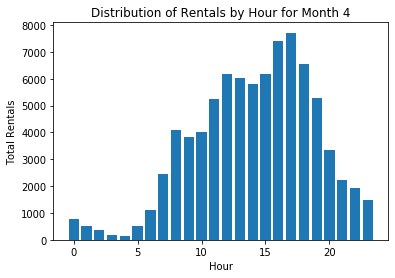

In [50]:
# For the filter month, display the distribution of bike rentals throughout the day, for all stations
task2_3 = get_ftr(inp_df, 'H')

fig, ax = plt.subplots()
ax.bar( range(0,24),task2_3.groupby('hour').fromCNT.sum() )
plt.title('Distribution of Rentals by Hour for Month '+str(int(filter_month)))
plt.xlabel('Hour')
plt.ylabel('Total Rentals')
plt.show()

### Task 2.4

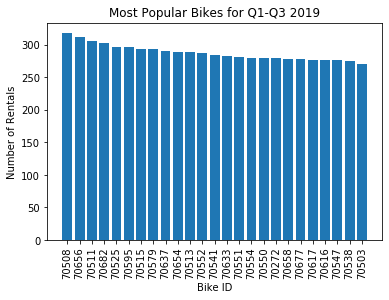

In [51]:
# Most popular bikes
task2_4 = full_df.groupby('Bikeid').trip_id.count()
task2_4 = task2_4.rename('num_rentals')

display2_4 = task2_4.sort_values(ascending=False).head(n=25)
x = [str(bid) for bid in display2_4.index]
fig, ax = plt.subplots()
plt.bar(x, display2_4)
plt.xticks(rotation=90)
plt.title('Most Popular Bikes for Q1-Q3 2019')
plt.xlabel('Bike ID')
plt.ylabel('Number of Rentals')
plt.show()

---
### Task 3

In this task you will create graphs to show the rebalancing issue.

### Task 3.1

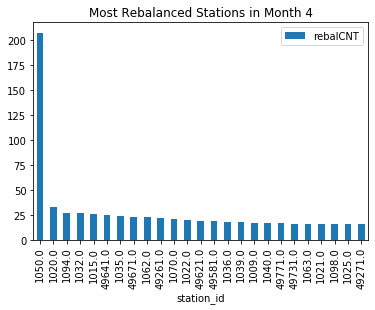

In [52]:
# Stations that recieve the most rebalancing 
task3_1  = task2_1_temp.drop(columns='month').sort_values(by='rebalCNT',ascending=False)
title3_1 = 'Most Rebalanced Stations in Month '+str(int(filter_month))
task3_1.head(n=25).plot(kind='bar',y='rebalCNT',title=title3_1)

### Task 3.2

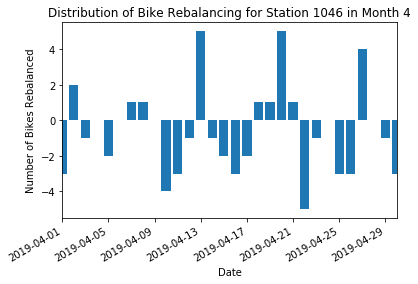

In [57]:
# For the filter month and station, displays the distribution of bike rebalancing
fig, ax = plt.subplots()
ax.bar(x=task2_2['date'],height=task2_2['rebalCNT'])
ax.xaxis_date()
fig.autofmt_xdate()
ax.set_xlim([dates[0], dates[-1]])
plt.title('Distribution of Bike Rebalancing for Station '+str(filter_stationID)+' in Month '+str(filter_month))
plt.xlabel('Date')
plt.ylabel('Number of Bikes Rebalanced')
plt.show()

---
### Task 4

In this task you will cluster the data to group similar stations together, using a variety of clustering functions and visualize the results of the clustering.

### Task 4.1

In [12]:
# Creates 6 -dimensional data for each station. Counts of departing bikes, and rebalanced bikes for 3 months
# Perform clustering on the 6-dimensional space using K-means and DBSCAN

def get_dims(df, st, fin):
    ret = pd.DataFrame()
    for i in range(st,fin+1):
        temp = df[df.month == i].drop(columns=['month','toCNT'])
        new_labs = []
        for lab in temp.columns :
            new_labs.append(lab+str(i))
        temp.columns = new_labs
        if ret.empty:
            ret = temp
        else :
            ret = ret.merge(temp, on='station_id', how='outer').fillna(0)
    return ret
        
task4_1 = task1_2.reset_index(level=1)
task4_1 = get_dims(task4_1, 7,9)


# K-Means
def k_means(df, k_df, k):
    kmeans = KMeans(n_clusters = k)
    kmeans.fit(df)
    y_means = kmeans.predict(df)
    d = Counter(y_means)
    sil = silhouette_score(df,y_means)
    s = pd.Series(data={'sil_score':sil,'counts':d}, name=k)
    return k_df.append(s)

k_df = pd.DataFrame(columns=['k','sil_score','counts'])
k_df = k_df.set_index('k')
for i in range(2,20):
    k_df = k_means(task4_1, k_df, i)

k_df = k_df.sort_values(by=['sil_score'], ascending=False)
     

# DBSCAN
def best_DBSCAN(df, db_df, mins):
    for i in range(10,100,5):
        db = DBSCAN(eps = i, min_samples = mins).fit(df)
        labels = db.labels_ 
        counts = Counter(labels)
        if len(counts) > 2:
            sil = silhouette_score(df,labels)
        else :
            sil = -1
        s = pd.Series(data={
                'min_samples':mins,'eps':i,'sil_score':sil,'counts':counts.values()}, 
                name= 'eps')
        db_df = db_df.append(s)
    return db_df.set_index(['min_samples','eps']).dropna()

db_df = pd.DataFrame(columns=['min_samples','eps','sil_score','counts'])
db_df = db_df.set_index(['min_samples','eps'])
db_df_list = []
for i in range(5,20):
    db_df_list.append(best_DBSCAN(task4_1, db_df, i))

sil_df = pd.DataFrame(columns=['sil_score','counts'])
for d in db_df_list:
    s = d.sort_values(by=['sil_score'], ascending=False).head(n=1).T.squeeze()
    sil_df = sil_df.append(s)    

db_res = sil_df.sort_values(by=['sil_score'],ascending=False)


### Task 4.2

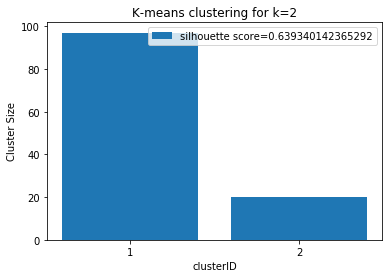

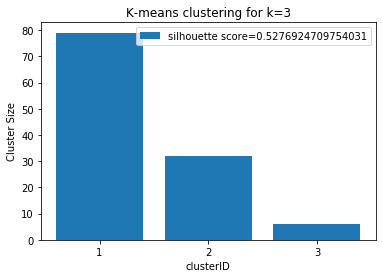

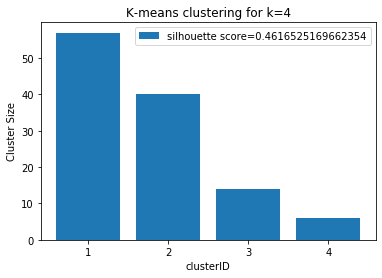

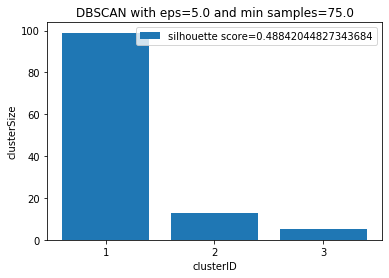

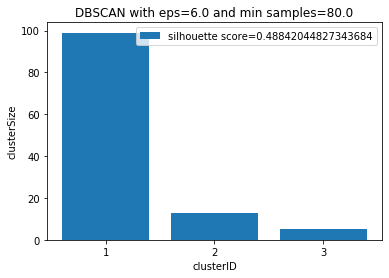

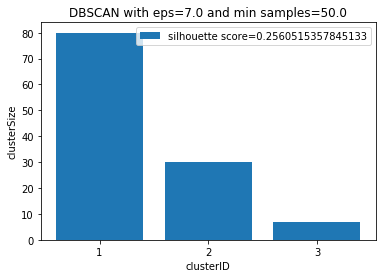

In [13]:
# Create K-Mean Boxplots
for k in k_df.head(n=3).iterrows():
    x = [str(i) for i in range(1,len(k[1].counts)+1)]
    lab='silhouette score='+str(k[1].sil_score)
    y = list(k[1].counts.values())
    list.sort(y,reverse=True)
    plt.bar(x, height=y, label=lab)
    plt.title('K-means clustering for k='+str(len(k[1].counts)))
    plt.xlabel('clusterID')
    plt.ylabel('Cluster Size')
    plt.legend()
    plt.show()

# Create DBSCAN Boxplots
for d in db_res.head(n=3).iterrows():
    x = [str(i) for i in range(1,len(d[1].counts)+1)]
    y = list(d[1].counts) 
    list.sort(y, reverse=True)
    lab = 'with eps='+str(d[0][0])+' and min samples='+str(d[0][1])
    plt.bar(x, height=y, label='silhouette score='+str(d[1].sil_score))
    plt.title('DBSCAN '+lab)
    plt.xlabel('clusterID')
    plt.ylabel('clusterSize')
    plt.legend()
    plt.show()

### Task 4.3

JUSTIFY PARAMETERS CHOICES:

I would choose a k value of 2 for the k-means algorithm on this data. I came to this conclusion by finding the silhouette scores for each of the resulting trained k-means algorithms. Displayed above are the k-means with the highest scores. These happened to be k-sizes 1, 2, and 3. As shown below, the this inverse trend between k-size and silhouette score continues, but has exceptions. 

I would choose either (epsilon: 5.0 and min sample: 75) or (epsilon: 6.0 and min sample: 80). Both of these are acceptable because my metric for judging algorithm quality is the silhouette score for each trained algorithm. I investigated the permutations of epsiolons 5-19 and minimum sample sizes 10-95. Displayed above are the 3 pairs that yielded the highest silhouette scores. Below, I have displayed the silhouette scores of each epsilon value's corresponding minimum sample pair with the largest silhouette score. DBSCANs that did not yield greater than 1 cluster were automatically assigned scores of  -1. 

In [14]:
print(k_df['sil_score'])
print()
print(db_res['sil_score'])

k
2     0.639340
3     0.527692
4     0.461653
6     0.457285
5     0.394549
7     0.386345
9     0.327660
10    0.323676
11    0.322421
12    0.317925
13    0.313838
15    0.311710
8     0.307897
14    0.298634
17    0.275353
18    0.267237
16    0.264901
19    0.263651
Name: sil_score, dtype: float64

(5.0, 75.0)     0.488420
(6.0, 80.0)     0.488420
(7.0, 50.0)     0.256052
(8.0, 50.0)     0.245945
(9.0, 30.0)     0.065242
(10.0, 30.0)    0.052680
(11.0, 10.0)   -1.000000
(12.0, 10.0)   -1.000000
(13.0, 10.0)   -1.000000
(14.0, 10.0)   -1.000000
(15.0, 10.0)   -1.000000
(16.0, 10.0)   -1.000000
(17.0, 10.0)   -1.000000
(18.0, 10.0)   -1.000000
(19.0, 10.0)   -1.000000
Name: sil_score, dtype: float64
